In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import load_processed_data as ld
import utils_model_evaluation as ume
import os
from definitions import MODELS_PATH, MODEL_NAMES, FIGURE_OUTPUT_PATH
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score

# Configuration

In [2]:
# adjust seaborn font scale
sns.set(font_scale=1.2)

# set the best model key
key_best_model = 2

# Prepare Data

In [3]:
# load test data
X, y_ohe, _ = ld.load_test_data()

# create a 1-D array of class labels encoded as integers
# NOTE: this implementation assumes y_ohe is correct without checking
y_true = np.argmax(y_ohe,
                   axis=1)

# get list of class labels
y_labels = ld.get_y_ohe_class_names()

# load the best model
mn = MODEL_NAMES[key_best_model]
model_file_path = MODELS_PATH + mn + '.h5'
m = load_model(model_file_path)

# get model predictions
if key_best_model in [2,3]:
    X_preprocessed = preprocess_input(X)
else:
    X_preprocessed = X / 255.0
y_pred = m.predict_classes(X_preprocessed)
y_pred_proba = m.predict_proba(X_preprocessed)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Pneumonia vs Normal

In [4]:
# create a 1-D array of encoded class labels for pneumonia vs normal
ynp_true = (y_true != y_labels.index('normal')).astype(np.uint8)

# class labels
ynp_labels = ['normal', 'pneumonia']

# predictions
ynp_pred = (y_pred != y_labels.index('normal')).astype(np.uint8)
ynp_pred_proba = np.stack((y_pred_proba[:, y_labels.index('normal')],
                             y_pred_proba[:, y_labels.index('bacterial_pneumonia')]
                             + y_pred_proba[:, y_labels.index('viral_pneumonia')]),
                          axis=1)

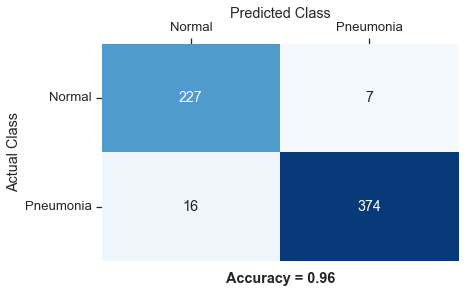

In [5]:
# get confusion matrix
df_np_cm = ume.get_confusion_matrix_df(y_true=ynp_true,
                                       y_pred=ynp_pred,
                                       y_labels=ynp_labels)

# make heatmap of confusion matrix
fig_np_cm = ume.get_confusion_matrix_heatmap_figure(df_np_cm)

# save the heatmap figure
heatmap_file_path = (FIGURE_OUTPUT_PATH
                     + mn
                     + '_normalVpneumonia_confusion_matrix_heatmap.png')
if os.path.exists(heatmap_file_path):
    os.remove(heatmap_file_path)
fig_np_cm.savefig(heatmap_file_path,
               bbox_inches='tight')

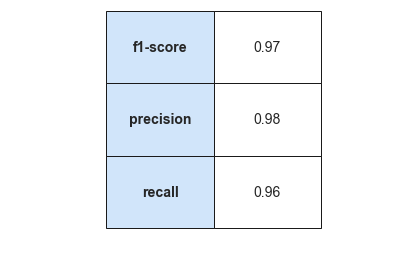

In [8]:
# get classification report
df_np_cr = ume.get_classification_report_df(y_true=ynp_true,
                                            y_pred=ynp_pred,
                                            y_labels=ynp_labels)

# get scores for Pneumonia
df_p_scores = df_np_cr.loc['Pneumonia', 'f1-score':'recall']
df_p_scores = df_p_scores.astype(str)

# create a figure
fig_np_cr = plt.figure(figsize=(6.4, 4))

# get the figure's axis
ax = fig_np_cr.gca()

# do not display the axis
ax.axis('off')

# create a table from the pneumonia scores
t = ax.table(cellText=list(zip(df_p_scores.index, df_p_scores.values)),
             cellLoc='center',
             loc='right',
             bbox=[0.2, 0, 0.6, 1])

for y in range(3):
    t[y, 0].set_facecolor('#d1e5fa')  # light blue
    t[y, 0].set_text_props(fontweight='bold')
    
# set number of digits to display
for y in range(3):
    t[y, 1].get_text().set_text('%.2f'
                                % float(t[y, 1].get_text().get_text()))

# set the font size
t.auto_set_font_size(False)
t.set_fontsize(14)

# save the table figure
table_file_path = (FIGURE_OUTPUT_PATH
                   + mn
                   + '_normalVpneumonia_classification_report.png')
if os.path.exists(table_file_path):
    os.remove(table_file_path)
fig_np_cr.savefig(table_file_path,
               bbox_inches='tight')

In [ ]:
# TO DO: implement ROC curve and get ROC-AUC.  Also implement precision-recall curve and get AUC as well as average precision.
# TO DO: implement loop over all 3 models, in order to make all output files for all 3 models.

# Bacterial vs Viral -- Conditional on Pneumonia